In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

from helpers.physics_functions import get_bins
from helpers.evaluation import get_median_percentiles
from helpers.stats_functions import parametric_fit
from helpers.data_transforms import scaled_to_physical_transform

from helpers.plotting import newplot, hist_with_outline, hist_with_errors, function_with_band, stamp
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manage")

np.seterr(divide='ignore')


plt.rcParams['text.usetex'] = False

In [2]:
import yaml
with open("workflow.yaml", "rb") as file:
    workflow = yaml.safe_load(file) 

# Setup

In [3]:
nbins = 40
bins = {
        "dimu_pt": np.linspace(0, 150, nbins),
        "dimu_eta": np.linspace(-3, 3, nbins),
        "mu0_pt": np.linspace(0, 120, nbins),
        "mu1_pt": np.linspace(0, 80, nbins),
        "mu0_eta": np.linspace(-3, 3, nbins),
        "mu1_eta": np.linspace(-3, 3, nbins),
        "mu0_ip3d": np.logspace(-3, 0, nbins),
        "mu1_ip3d": np.logspace(-3, 0, nbins),
        "mu0_iso04": np.logspace(np.log10(0.55), 2, nbins),
        "mu1_iso04": np.logspace(np.log10(0.55), 2, nbins),
        "mumu_deltapT": np.linspace(0, 100, nbins),
        "mumu_deltaR": np.linspace(0, 1, nbins),
    }    

#https://gist.github.com/Myndex/997244b95d84788df96f4aab8b9edeb1
  

colors_dict = {
        "dimu_pt":  "#d32b1e",
        "dimu_eta": "#2b3514",
        "mu0_pt": "#e8e948",
        "mu1_pt": "#d485b2",
        "mu0_eta": "#6f340d",
        "mu1_eta": "#ba1c30",
        "mu0_ip3d": "#91218c",
        "mu1_ip3d": "#e1a11a",
        "mu0_iso04": "#df8461" ,
        "mu1_iso04": "#7e1510",
        "mumu_deltapT":  "#96cde6",
        "mumu_deltaR":"#db6917",
       "CATHODE":"#4277b6" ,
       "full_likelihood":"#702c8c",
    }    
labels = {
        "dimu_pt": "Dimuon $p_T$ [GeV]",
        "dimu_eta": "Dimuon $\eta$",
        "mu0_pt": "Muon 1 $p_T$ [GeV]",
        "mu1_pt": "Muon 2 $p_T$ [GeV]",
        "mu0_eta": "Muon 1 $\eta$",
        "mu1_eta": "Muon 2  $\eta$",
        "mu0_ip3d": "Muon 1 IP3D [cm]",
        "mu1_ip3d": "Muon 2 IP3D [cm]",
        "mu0_iso04": "Muon 1 iso04",
        "mu1_iso04": "Muon 2 iso04",
        "mumu_deltapT": "Muon $\Delta p_T$ [GeV]",
        "mumu_deltaR": "Muon $\Delta R$",
    }

plot_log = {
        "dimu_pt":False,
        "dimu_eta": False,
        "mu0_pt": False,
        "mu1_pt": False,
        "mu0_eta": False,
        "mu1_eta": False,
        "mu0_ip3d": True,
        "mu1_ip3d": True,
        "mu0_iso04": True,
        "mu1_iso04":True,
        "mumu_deltapT": False,
        "mumu_deltaR": False,
    }

In [4]:
bin_percent = {8: 2.3, 12: 1.5, 16: 1.1}
num_bins_SR = 12 # 16, 12, 8
pseudo_e_to_plot = 0 # this plots the actual data (not a boostrapped version)

# basically hard-coded for the PRL 
num_pseudoexperiments = 100
n_folds = 5
particle_type = "upsilon_iso"
particle_id = "upsilon"
ONE_SIDED = True

# Needed for Classical Studies
config_id = "CATHODE_8"
project_id = "lowmass"
bootstrap_flow = 0

In [5]:
fit_degree = 5
fit_type = "Quintic"
flow_id = "double_2"
feature_id = flow_id

master_title = "$\\bf{2016 CMS Open DoubleMuon}$\n$\\tt{HLT\_TrkMu15\_DoubleTrkMu5NoFiltersNoVtx}$\n8.7 fb$^{-1}$, $\sqrt{s} = 13$ Te\nFeature Set $\\tt{double\_2}$"
master_line1 = f"Bin width = {bin_percent[num_bins_SR]}$\%$"
master_line2 = f"Fit Type: {fit_type.capitalize()}"
master_line3 = "$\mu$ iso04 $\geq$ 0.55"

"""
# somewhat complicated code to set naming conventions
if train_samesign:
    train_data_id = "SS"
else:
    train_data_id = "OS"

# train on opp sign means alt test set is samesign
if train_data_id == "": 
    alt_test_data_id = "SS"
    train_data_id_title = "OS"
elif train_data_id == "SS": 
    alt_test_data_id = ""
    train_data_id_title = "SS"
"""
flow_training_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/" + workflow["analysis_keywords"]["name"]+f"/models/bootstrap{bootstrap_flow}_OS/{feature_id}/{config_id}/"
plot_data_dir = f"plot_data/{flow_id}/"
plot_save_dir = f"plots/{flow_id}/"
os.makedirs(plot_save_dir, exist_ok=True)


print(f"Loading data from {flow_training_dir}")
with open(f"{flow_training_dir}/seed1/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    feature_set = [x.strip() for x in configs.split("'")][1::2][:-1]

print(f"Feature Set: {feature_set}")



data_prefix = f"upsilon_OS"
data_prefix_SS = f"upsilon_SS"
print(data_prefix)

Loading data from /global/cfs/cdirs/m3246/rmastand/dimuonAD//projects/upsilon_iso_03_03/models/bootstrap0_OS/double_2/CATHODE_8/
Feature Set: ['mumu_deltaR', 'mumu_deltapT']
upsilon_OS


In [6]:
SB_left = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SB_left"])
SR_left = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SR_left"])
SR_right = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SR_right"])
SB_right = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SB_right"])

print(f"SR: {SR_left}, {SR_right}")
print(f"SB: {SB_left}, {SB_right}")

fprs_to_plot = [1, 0.25, 0.1, 0.01, 0.005]

SR: 9.0, 10.6
SB: 5.0, 16.0


In [7]:
with open(f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/upsilon_iso_03_03/processed_data/no_iso_cut_SR_OS", "rb") as ifile:
    isolation_data_OS_SR = pickle.load(ifile)
with open(f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/upsilon_iso_03_03/processed_data/no_iso_cut_SR_SS", "rb") as ifile:
    isolation_data_OS_SR = pickle.load(ifile)




# Cut Histograms

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import numpy as np

# Color conversion filters
def rgb_to_gray(color):
    """Convert an RGB color to grayscale using luminosity."""
    return 0.2989 * color[0] + 0.5870 * color[1] + 0.1140 * color[2]

def rgb_to_rg_colorblind(color):
    """Convert an RGB color to a simulated red-green colorblind palette."""
    # Transformation matrix for RG colorblind simulation
    # Approximation for protanopia or deuteranopia
    colorblind_matrix = np.array([
        [0.567, 0.433, 0.0],
        [0.558, 0.442, 0.0],
        [0.0, 0.242, 0.758]
    ])
    return np.clip(np.dot(colorblind_matrix, color), 0, 1)

def apply_color_filter(color, filter_function):
    """General function to apply a filter to a color."""
    if isinstance(color, str):  # Convert named color to RGB
        color = mcolors.to_rgb(color)
    filtered_color = filter_function(color)
    if np.isscalar(filtered_color):  # Grayscale outputs a single value
        return (filtered_color, filtered_color, filtered_color)
    return tuple(filtered_color)

# Plot element updates
def update_lines(ax, filter_function):
    for line in ax.get_lines():
        color = line.get_color()
        new_color = apply_color_filter(color, filter_function)
        line.set_color(new_color)

def update_patches(ax, filter_function):
    for patch in ax.patches:
        face_color = patch.get_facecolor()
        edge_color = patch.get_edgecolor()
        new_face_color = apply_color_filter(face_color[:3], filter_function) + (face_color[3],)
        new_edge_color = apply_color_filter(edge_color[:3], filter_function) + (edge_color[3],)
        patch.set_facecolor(new_face_color)
        patch.set_edgecolor(new_edge_color)

def update_collections(ax, filter_function):
    for collection in ax.collections:
        face_colors = collection.get_facecolor()
        edge_colors = collection.get_edgecolor()
        if len(face_colors) > 0:
            new_face_colors = [
                apply_color_filter(fc[:3], filter_function) + (fc[3],) for fc in face_colors
            ]
            collection.set_facecolor(new_face_colors)
        if len(edge_colors) > 0:
            new_edge_colors = [
                apply_color_filter(ec[:3], filter_function) + (ec[3],) for ec in edge_colors
            ]
            collection.set_edgecolor(new_edge_colors)

def update_legend(ax, filter_function):
    legend = ax.get_legend()
    if legend:
        for text in legend.get_texts():
            text.set_color("black")  # Keep legend text black
        for handle in legend.legendHandles:
            if isinstance(handle, mpatches.Patch):  # Patches (e.g., histograms)
                face_color = handle.get_facecolor()
                edge_color = handle.get_edgecolor()
                new_face_color = apply_color_filter(face_color[:3], filter_function) + (face_color[3],)
                new_edge_color = apply_color_filter(edge_color[:3], filter_function) + (edge_color[3],)
                handle.set_facecolor(new_face_color)
                handle.set_edgecolor(new_edge_color)
            elif hasattr(handle, 'get_color'):  # Lines
                color = handle.get_color()
                new_color = apply_color_filter(color, filter_function)
                handle.set_color(new_color)

def apply_color_filter_to_plot(ax, filter_function):
    """Apply a color filter to all elements of a plot."""
    update_lines(ax, filter_function)
    update_patches(ax, filter_function)
    update_collections(ax, filter_function)
    update_legend(ax, filter_function)
    # Axes ticks and spines
    ax.tick_params(colors='black')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')

    return ax

In [9]:
def plot_upsilon_resonances(ax):

    # plot the upsilon resonances
    ax.axvline(9.460, color="black", linestyle="--", alpha=0.15, lw = 1.5)
    ax.text(9.460 * 0.995, 1e4, "$\\Upsilon(1S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=5)
    ax.axvline(10.023, color="black", linestyle="--", alpha=0.15, lw = 1.5)
    ax.text(10.023 * 0.995, 1e4, "$\\Upsilon(2S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=5)
    ax.axvline(10.355, color="black", linestyle="--", alpha=0.15, lw = 1.5)
    ax.text(10.355 * 0.995, 1e4, "$\\Upsilon(3S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=5)
   

def plot_histograms_with_fits(save_data, SB_left, SR_left, SR_right, SB_right, upsilon_lines = True, colors = None, alphas = None, line_0 = None, line_1 = None):
    
    num_points = 6

    fpr_thresholds = save_data["fpr_thresholds"]
    #print(fpr_thresholds)
    num_bins_SR = save_data["num_bins_SR"]
    popts = save_data["popts"]
    pcovs = save_data["pcovs"]
    significances = save_data["significances"]
    filtered_masses = save_data["filtered_masses"]
    y_vals = save_data["y_vals"]

    # define bins and bin edges for the SB and SR
    # change the bin width with `num_bins_SR`
    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)


    fig, ax = newplot("column", width = 5, height = 5)


    if colors is None:
        colors = ['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']
    if alphas is None:
        alphas = np.linspace(1, 0.5, len(fpr_thresholds))[::-1]

    # colors = [((i) * np.power(i, 0.25), 0 , (1-i) * np.power(i, 0.25)) for i in np.linspace(0, 1, len(fpr_thresholds))]

    # # plot the iso data
    # filtered_masses_iso = filtered_masses[-1]
    # popt_iso = popts[-1]
    # pcov_iso = pcovs[-1]
    # total_events_iso = len(filtered_masses_iso)
    # significance_iso = significances[-1]
    # y_vals_iso = y_vals[-1]

    # # plot the fit function
    # plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt_iso), lw = 2, linestyle = "dashed", color = "black")
    # function_with_band(ax, fit_function, [SB_left, SB_right], popt_iso, pcov_iso, color = "black", alpha_band = 0.2, alpha_line = 0.85, linestyle = "dashed", lw = 2)

    # # plot the data
    # label_string = "Pre-Anti-Iso, $Z_0$: "+str(round(significance_iso,2))
    # # plt.hist(filtered_masses_iso, bins = plot_bins_all, lw = 3, histtype = "step", color = "black",label = label_string, alpha = 0.75)
    # hist_with_outline(ax, filtered_masses_iso, bins = plot_bins_all, range = (SB_left, SB_right), color = "black", label = label_string, alpha_1 = 0.005, lw = 1.5, alpha_2 = 0.75)
    



    
    for t, threshold in enumerate(fprs_to_plot):

        #if t % 2 == 1:
            #continue
        
        filtered_masses_t = filtered_masses[t]
        popt = popts[t]
        pcov = pcovs[t]
        total_events = len(filtered_masses_t)
        significance = significances[t]
        y_vals_t = y_vals[t]

        #print(plot_centers_SB.shape, y_vals_t.shape)
        
        # plot the fit function
        plt.plot(plot_centers_all, parametric_fit(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = colors[t])    
        function_with_band(ax, parametric_fit, [SB_left, SB_right], popt, pcov, color = colors[t], alpha_band = 0.2, alpha_line = 0.85, linestyle = "dashed", lw = 2)

        # plot the data
        label_string = str(round(100*threshold, 2))+"$\%$, "+str(round(significance,2)) + "$\sigma$"
        # plt.hist(filtered_masses_t, bins = plot_bins_all, lw = 3, histtype = "step", color = colors[t],label = label_string, alpha = 0.75)
        hist_with_outline(ax, filtered_masses_t, bins = plot_bins_all, range = (SB_left, SB_right), color = colors[t], label = label_string, alpha_1 = 0.005, lw = 1.5, alpha_2 = alphas[t])
        # plt.scatter(plot_centers_SB, y_vals_t, color = colors[t], alpha = 0.5)




    #line2 = "8.7 fb$^{-1}$"
    #line3 = "$\sqrt{s} = 13$ TeV"
    line4 = "$\mu$ iso04 $\geq$ 0.55"

    starting_x = 0.0400
    starting_y = 0.95
    delta_y = 0.055
    text_alpha = 0.75

    if line_0 is not None:
        ax.text(starting_x, starting_y - (0) * delta_y, line_0, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha)
    if line_1 is not None:
        ax.text(starting_x, starting_y - (1) * delta_y, line_1, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha)
   # ax.text(starting_x, starting_y - 2 * delta_y, line2, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha)
    #ax.text(starting_x, starting_y - 3 * delta_y, line3, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 2 * delta_y, master_line1, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 3 * delta_y, master_line2, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 4 * delta_y, master_line3, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha)


    #legend_title = title
    # plt.legend(loc = (0.485, 0.575), fontsize = 9, title = legend_title, title_fontsize = 11)
    plt.legend(loc = "upper right", fontsize = 9, title = "False Positive Rate", title_fontsize = 10)


    plt.title(master_title, fontsize = 10, loc = "right")


    plt.axvline(SR_left, color= "k", lw = 1.5, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 1.5, zorder = 10)

    plt.xlabel("Dimuon Mass $m_{\mu\mu}$ [GeV]")
    plt.ylabel("Events",)

    plt.yscale("log")
    # plt.ylim(0.5, 1e3)
    plt.xlim(SB_left, SB_right)
    plt.ylim(0.01, 1e5)

    # Add more x ticks (major and minor)
    plt.xticks()
    plt.yticks()
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)

    if upsilon_lines:
        plot_upsilon_resonances(ax)

    return fig, ax

    # apply_color_filter_to_plot(ax, rgb_to_gray)
    # apply_color_filter_to_plot(ax, rgb_to_rg_colorblind)
        

Bad value in file '/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/style_column_notex.mplstyle', line 39 ('text.usetex : False:'): Key text.usetex: Cannot convert 'false:' to bool


File to open:  plot_data/lowmass_upsilon_iso_OS_nojet_histogram_data_5_12.pickle
File to open:  plot_data/double_2/upsilon_OS_histogram_data_5_12.pickle


Bad value in file '/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/style_column_notex.mplstyle', line 39 ('text.usetex : False:'): Key text.usetex: Cannot convert 'false:' to bool
Bad value in file '/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/style_column_notex.mplstyle', line 39 ('text.usetex : False:'): Key text.usetex: Cannot convert 'false:' to bool
Bad value in file '/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/style_column_notex.mplstyle', line 39 ('text.usetex : False:'): Key text.usetex: Cannot convert 'false:' to bool


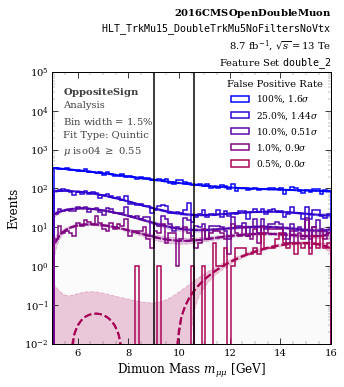

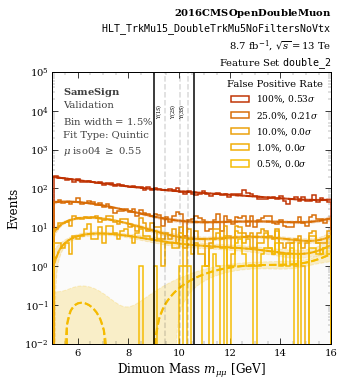

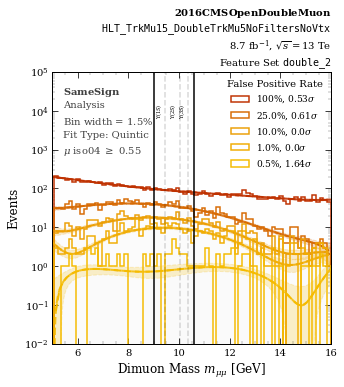

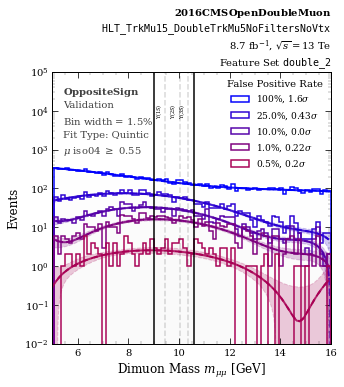

In [10]:

num_points = 7
bsx_c = [((0.99 * i) * np.power(i, 0), 0 , 0.99*(1-i) * np.power(i, 0.0)) for i in np.linspace(0, 1, num_points)]
bsx_a = np.linspace(0.99, 0.99, num_points)

# Red Yellow Green color scheme
# 8ea604-c2b102-f5bb00-f1ad03-ec9f05-d76a03-bf3100
ryg_c = ['#6A7D04', '#758904', "#819704", "#c2b102", "#f5bb00", "#f1ad03", "#ec9f05", "#d76a03", "#bf3100"][::-1]
ryg_a = np.linspace(0.99, 1, num_points)


# Plot the CATHODE
print("File to open: ", f"plot_data/lowmass_upsilon_iso_OS_nojet_histogram_data_{fit_degree}_12.pickle")
print("File to open: ", f"{plot_data_dir}{data_prefix}_histogram_data_{fit_degree}_{num_bins_SR}.pickle")
with open(f"{plot_data_dir}{data_prefix}_histogram_data_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    hist_data = pickle.load(file)
fig, ax = plot_histograms_with_fits(hist_data, SB_left, SR_left, SR_right, SB_right, upsilon_lines = False, colors = bsx_c, alphas = bsx_a, line_0 = "$\\bf{OppositeSign}$", line_1 = "Analysis")
# apply_color_filter_to_plot(ax, rgb_to_gray)
# apply_color_filter_to_plot(ax, rgb_to_rg_colorblind)
fig.show()
plt.savefig(f"{plot_save_dir}/histogram_{fit_degree}_{num_bins_SR}_{flow_id}.pdf", bbox_inches = "tight")

# Plot the Same Sign VALIDATION CATHODE
with open(f"{plot_data_dir}{data_prefix}_histogram_data_alt_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    hist_data_alt = pickle.load(file)
fig, ax = plot_histograms_with_fits(hist_data_alt, SB_left, SR_left, SR_right, SB_right, upsilon_lines = True, colors = ryg_c, alphas = ryg_a, line_0 = "$\\bf{SameSign}$", line_1 = "Validation")
# apply_color_filter_to_plot(ax, rgb_to_gray)
plt.savefig(f"{plot_save_dir}/histogram_alt_{fit_degree}_{num_bins_SR}_{flow_id}.pdf", bbox_inches = "tight")



# # Plot the Same Sign  CATHODE
with open(f"{plot_data_dir}{data_prefix_SS}_histogram_data_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    hist_data_SS = pickle.load(file)
fig, ax = plot_histograms_with_fits(hist_data_SS, SB_left, SR_left, SR_right, SB_right, upsilon_lines = True, colors = ryg_c, alphas = ryg_a, line_0 = "$\\bf{SameSign}$", line_1 = "Analysis")
plt.savefig(f"{plot_save_dir}/histogram_SS_{fit_degree}_{num_bins_SR}_{flow_id}.pdf", bbox_inches = "tight")


# # Plot the Same Sign  CATHODE
with open(f"{plot_data_dir}{data_prefix_SS}_histogram_data_alt_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    hist_data_SS = pickle.load(file)
fig, ax = plot_histograms_with_fits(hist_data_SS, SB_left, SR_left, SR_right, SB_right, upsilon_lines = True, colors = bsx_c, alphas = ryg_a, line_0 = "$\\bf{OppositeSign}$", line_1 = "Validation")
plt.savefig(f"{plot_save_dir}/histogram_SS_alt_{fit_degree}_{num_bins_SR}_{flow_id}.pdf", bbox_inches = "tight")



# Feature Histograms

In [11]:
with open(f"{plot_data_dir}{data_prefix}_feature_data_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    feature_data = pickle.load(file)

In [12]:
def plot_features(save_data, colors, alphas):

    num_points = 7
    fpr_thresholds = save_data["fpr_thresholds"]
    filtered_features_all = save_data["features"]


    n_features = len(feature_set) 
    nbins = 35

    




    
    fig, ax = newplot("column", width = 3*n_features, height = 3, subplot_array=(1, n_features))
    # fig, ax = plt.subplots(1, n_features, figsize = (9, 3))

    #Plot the iso data
    for i_feat in range(n_features):

        feature = isolation_data_OS_SR[feature_set[i_feat]]
        label_string = "Pre Anti-Isolation Cut"

        ax[i_feat].hist( feature, bins=bins[feature_set[i_feat]], lw = 1.0, histtype = "step", color = "black",label = label_string, alpha = 0.75, ls = "--")
        # ax[i_feat].hist( feature, bins=bins[feature_set[i_feat]], lw = 1.5, histtype = "stepfilled", color = "black", alpha = 0.25)
        

    
    for t, threshold in enumerate(fprs_to_plot):

        #if t % 2 == 1:
            #continue

        filtered_features = filtered_features_all[t]
        
   
        for i_feat in range(n_features):

            label_string = str(round(100*threshold, 2))+"$\%$ FPR"

            white_color = (np.array([4, 4, 4]) + colors[t])/5
            

            ax[i_feat].hist( filtered_features[i_feat], bins=bins[feature_set[i_feat]], lw = 1.5, histtype = "step", color = colors[t],label = label_string, alpha = alphas[t])
            ax[i_feat].hist( filtered_features[i_feat], bins=bins[feature_set[i_feat]], lw = 1.5, histtype = "stepfilled", color = white_color, alpha = 0.99)
            ax[i_feat].set_yscale("log")



            if plot_log[feature_set[i_feat]]:
                ax[i_feat].set_xscale("log")
            ax[i_feat].set_xlabel(labels[feature_set[i_feat]])
            ax[i_feat].set_ylim(5e-1, 2e3)

            ax[i_feat].tick_params()

            if i_feat > 0:
                ax[i_feat].set_yticklabels([])

    starting_x = 0.075
    starting_y = 0.955
    delta_y = 0.08
    text_alpha = 0.75

    line0 = "$\\bf{OppositeSign}$"
    line4 = "Analysis"
   

    #if line0 is not None:
        #ax[1].text(starting_x, starting_y - (0) * delta_y, line0, transform=ax[1].transAxes, fontsize=7, verticalalignment='top', alpha = text_alpha, zorder = 10)
        #ax[1].text(starting_x, starting_y - (1) * delta_y, line0, transform=ax[1].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)


    ax[-2].text(starting_x, starting_y - 0 * delta_y, line0, transform=ax[-2].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    ax[-2].text(starting_x, starting_y - 1 * delta_y, line4, transform=ax[-2].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    
    ax[-1].text(starting_x, starting_y - 0 * delta_y, master_line1, transform=ax[-1].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    ax[-1].text(starting_x, starting_y - 1 * delta_y, master_line2, transform=ax[-1].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    ax[-1].text(starting_x, starting_y - 2 * delta_y, master_line3, transform=ax[-1].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)

    plt.title(master_title, fontsize = 10, loc = "right")
           

    legend_title = "Upsilon Resonances: Iso, Opp. Sign"
    plt.legend(loc = (-n_features+1, 1))

    ax[0].set_ylabel("Events")
    plt.subplots_adjust(wspace=0)



    return save_data
    
    

Bad value in file '/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/style_column_notex.mplstyle', line 39 ('text.usetex : False:'): Key text.usetex: Cannot convert 'false:' to bool


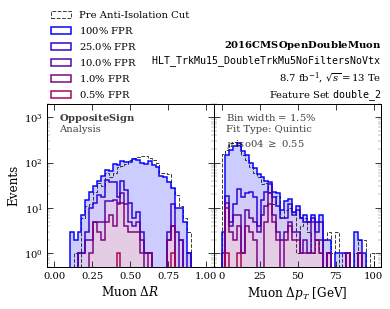

In [13]:
feature_data = plot_features(feature_data, bsx_c, bsx_a)
plt.savefig(f"{plot_save_dir}/features_{fit_degree}_{num_bins_SR}_{flow_id}.pdf", bbox_inches = "tight")

# Significances 

In [14]:
fpr_thresholds_finegrained = np.logspace(-3, 0, 25)[::-1]

feature_sigs = {}
random_sigs = {}

for feature in feature_set:
    with open(f"{plot_data_dir}{data_prefix}_significances_{feature}_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
        feature_sigs[feature] = pickle.load(file)


with open(f"{plot_data_dir}{data_prefix}_significances_random_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    random_sigs = pickle.load(file)


with open(f"{plot_data_dir}{data_prefix}_significances_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    feature_sigs["CATHODE"] = pickle.load(file)

with open(f"{plot_data_dir}{data_prefix}_full_q0_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    full_q0  = pickle.load(file)
print(full_q0)
# Get alt
feature_sigs_alt = {}
random_sigs_alt = {}

for feature in feature_set:
    with open(f"{plot_data_dir}{data_prefix}_significances_alt_{feature}_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
        feature_sigs_alt[feature] = pickle.load(file)

with open(f"{plot_data_dir}{data_prefix}_significances_alt_random_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    random_sigs_alt = pickle.load(file)

with open(f"{plot_data_dir}{data_prefix}_significances_alt_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    feature_sigs_alt["CATHODE"] = pickle.load(file)

with open(f"{plot_data_dir}{data_prefix}_full_q0_alt_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    full_q0_alt  = pickle.load(file)


# Get SS
feature_sigs_SS = {}
random_sigs_SS = {}

for feature in feature_set:
    with open(f"{plot_data_dir}{data_prefix_SS}_significances_{feature}_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
        feature_sigs_SS[feature] = pickle.load(file)

with open(f"{plot_data_dir}{data_prefix_SS}_significances_random_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    random_sigs_SS = pickle.load(file)

with open(f"{plot_data_dir}{data_prefix_SS}_significances_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    feature_sigs_SS["CATHODE"] = pickle.load(file)

with open(f"{plot_data_dir}{data_prefix_SS}_full_q0_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    full_q0_SS  = pickle.load(file)


 # Get SS alt
feature_sigs_SS_alt = {}
random_sigs_SS_alt = {}

for feature in feature_set:
    with open(f"{plot_data_dir}{data_prefix_SS}_significances_alt_{feature}_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
        feature_sigs_SS_alt[feature] = pickle.load(file)

with open(f"{plot_data_dir}{data_prefix_SS}_significances_alt_random_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    random_sigs_SS_alt = pickle.load(file)

with open(f"{plot_data_dir}{data_prefix_SS}_significances_alt_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    feature_sigs_SS_alt["CATHODE"] = pickle.load(file)

with open(f"{plot_data_dir}{data_prefix_SS}_full_q0_alt_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    full_q0_SS_alt  = pickle.load(file)


    

1.9567494944589043


In [15]:
import matplotlib.patches as mpatches
from scipy.stats import norm


def get_median_percentiles(x_array):
    
    x_median = np.median(x_array, axis = 1)
    x_lower = np.percentile(x_array, 16, axis = 1)
    x_upper = np.percentile(x_array, 84, axis = 1)

    x_2lower = np.percentile(x_array, 2.5, axis = 1)
    x_2upper = np.percentile(x_array, 97.5, axis = 1)

    return x_median, x_lower, x_upper, x_2lower, x_2upper


def inverse_quantile(sigma):

    return 1 - norm.cdf(sigma)



def plot_sig(feature_sigs, random_sigs, ymax = 10, ymin = 1e-15, bonus = None, line_0 = None, line_1 = None):


    # FPR Variant of SIC
    fig, ax = newplot("column",width = 5, height = 5)



    min_x = 2e-4



    # Plot the random cut
    # SIG_random_median, _, _ ,_ ,_ = get_median_percentiles(random_sigs[:,1:])
    SIG_random_observed = random_sigs[:,0]
    p_values = inverse_quantile(SIG_random_observed)
    plt.plot(fpr_thresholds_finegrained, p_values, color = "black", lw = 3, alpha = 0.75, marker = "o", ms = 0, label = "Random Cut", ls = "--")
    plt.plot(fpr_thresholds_finegrained, p_values, color = "black", lw = 0, alpha = 0.99, marker = "o", ms = 0)


    # primary_colors = ["red",  "blue"]
    # colors = ["lightcoral",  "cornflowerblue"]

    for (i, key) in enumerate(feature_set + ["CATHODE"]):


        # SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_sigs[key][:,1:])
        SIG_observed = feature_sigs[key][:,0]
        p_values = inverse_quantile(SIG_observed)

        if key == "CATHODE":
            markersize = 5
            linestyle = "-"
            label = "CATHODE"
            
        else:
            markersize = 0
            linestyle = "--"
            label = labels[key]

        ax.plot(fpr_thresholds_finegrained, p_values, color = colors_dict[key],lw = 3, alpha = 0.75, marker = "o", ms = markersize, label = label, ls = linestyle)
        ax.plot(fpr_thresholds_finegrained, p_values, color = colors_dict[key], lw = 0, alpha = 0.99, marker = "o", ms = markersize)


        # # Plot the maximum observed significance
        max_observed = np.nanmax(SIG_observed)
        # plt.scatter(min_x*1.05, max_observed, color = primary_colors[i], zorder = 1000, marker="*", s = 100)
        # plt.plot([min_x, min_x*3], [max_observed, max_observed], color = primary_colors[i], linestyle = "dashed", alpha = 0.5, lw = 1)
        # plt.text(min_x * 1.15, max_observed + 0.35, f"Max: {max_observed:.1f}$\sigma$", color = primary_colors[i], fontsize = 10, verticalalignment = "cente")

        #print(f"{key}: {max_observed}")

        argmax = np.argmax(SIG_observed)
        #print(f"{key}: {fpr_thresholds_finegrained[argmax]}")
        #print(f"{key}: {p_values[argmax]}")


    # Plot the bonus
    if bonus is not None:
        p_value = inverse_quantile(bonus)
        plt.axhline(p_value, color = colors_dict["full_likelihood"], lw = 3, alpha = 0.75, ms = 3, label = "$\ell$-Reweighting")


    # # add text 
    # plt.text(min_x * 1.15, SIG_random_observed[0] + 0.35, f"Original: {SIG_random_observed[0]:.1f}$\sigma$", color = "black", fontsize = 10, verticalalignment = "cente")


    #print(feature_sigs["CATHODE"][:,0])



    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("Background-Only $p$-Value")

    plt.yscale("log")

    #line_0 = "\\bf{Opposite Sign} Muons"
    #if ymax < 10:
    #    line_0 = "\\bf{Same Sign} Muons"

        
    line1 = f"Bin width = {bin_percent[num_bins_SR]}$\%$"
    line2 = f"Fit Type: {fit_type.capitalize()}"
    line3 = "$\mu$ iso04 $\geq$ 0.55"
    #line4 = "8.7 fb$^{-1}$, $\sqrt{s} = 13$ TeV"

    starting_x = 0.65
    starting_y = 0.18
    delta_y = 0.05
    text_alpha = 0.75

    if line_0 is not None:
        ax.text(starting_x, starting_y - (-2) * delta_y, line_0, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    if line_1 is not None:
        ax.text(starting_x, starting_y - (-1) * delta_y, line_1, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)

    ax.text(starting_x, starting_y - 0 * delta_y, master_line1, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    ax.text(starting_x, starting_y - 1 * delta_y, master_line2, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    ax.text(starting_x, starting_y - 2 * delta_y, master_line3, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    #ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)


    legend_title = "$\\bf{2016\,\, CMS\,\, Open\,\, Data\,\, DoubleMuon}$\n$\\tt{HLT\_TrkMu15\_DoubleTrkMu5NoFiltersNoVtx}$"
    plt.legend(loc = "lower left", ncol = 1, fontsize = 9)    
    #plt.title(master_title, loc = "right", fontsize = 10)

    # thin vertical line at 1e-4
    plt.axvline(1e-4, color = "grey", linestyle = "dashed", alpha = 0.5, lw = 1)


    # Plot sigmas
    i = 0
    while inverse_quantile(i) > ymin:
        p_value = inverse_quantile(i)
        plt.axhline(p_value, color = "grey", linestyle = "dashed", alpha = 0.5, lw = 1)

        if i > 0 and inverse_quantile(i+1) > ymin:
            plt.text(3e-4, p_value * 1.5, f"{i}$\sigma$", fontsize = 10, verticalalignment = "center")

        # fill above
        plt.fill_between([min_x, 1], p_value, 0.5, color = "grey", alpha = 0.025)

        i += 1

    # plt.legend(title = legend_title, loc = "upper cente", ncol = 2, fontsize = 14)
    plt.xscale("log")
    plt.ylim(ymin, 0.5)
    plt.xlim(min_x, 1)
    # plt.yscale("log")

    # ax.plot(FPR_median, SIC_median, color = "black", label = "CATHODE")
    # ax.fill_between(FPR_median, SIC_lower, SIC_upper, alpha = 0.3, color = "black")
    # ax.plot(FPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey", label = "Random Cut")
    # ax.set_xlabel("FP")
    # ax.set_ylabel("Signifance Improvement")

    # legend_title = "Original Signifiance = {###}"
    # plt.legend(title = legend_title, loc = "upper right")
    # plt.xscale("log")
    # plt.ylim(0, 6)

    return fig, ax

    plt.savefig(f"{plot_save_dir}/significance_{fit_type}_{num_bins_SR}.pdf")



Bad value in file '/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/style_column_notex.mplstyle', line 39 ('text.usetex : False:'): Key text.usetex: Cannot convert 'false:' to bool


1.39883862345122


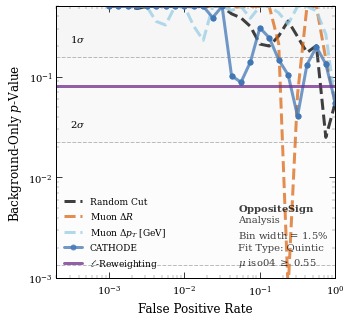

In [21]:
print(np.sqrt(full_q0))
fig, ax = plot_sig(feature_sigs, random_sigs, bonus = np.sqrt(full_q0), ymin = 1e-3, line_0 = "$\\bf{OppositeSign}$", line_1 = "Analysis")
plt.savefig(f"{plot_save_dir}/significance_{fit_type}_{num_bins_SR}_{flow_id}.pdf", bbox_inches = "tight")



Bad value in file '/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/style_column_notex.mplstyle', line 39 ('text.usetex : False:'): Key text.usetex: Cannot convert 'false:' to bool


0.5360447255246455


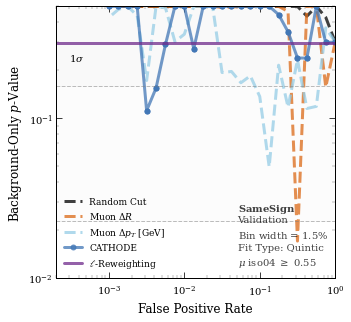

In [31]:
print(np.sqrt(full_q0_alt))
fig, ax = plot_sig(feature_sigs_alt, random_sigs_alt, ymax = 5, ymin=1e-2, bonus = np.sqrt(full_q0_alt), line_0 = "$\\bf{SameSign}$", line_1 = "Validation")
plt.savefig(f"{plot_save_dir}/significance_alt_{fit_type}_{num_bins_SR}_{flow_id}.pdf", bbox_inches = "tight")


Bad value in file '/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/style_column_notex.mplstyle', line 39 ('text.usetex : False:'): Key text.usetex: Cannot convert 'false:' to bool


0.5371690071361125


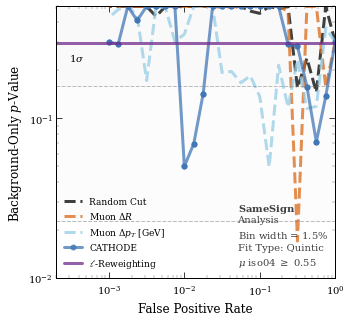

In [29]:

print(np.sqrt(full_q0_SS))
fig, ax = plot_sig(feature_sigs_SS, random_sigs_SS, ymax = 5, ymin=1e-2, bonus =  np.sqrt(full_q0_SS), line_0 = "$\\bf{SameSign}$", line_1 = "Analysis")
plt.savefig(f"{plot_save_dir}/significance_SS_{fit_type}_{num_bins_SR}_{flow_id}.pdf", bbox_inches = "tight")


Bad value in file '/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/style_column_notex.mplstyle', line 39 ('text.usetex : False:'): Key text.usetex: Cannot convert 'false:' to bool


0.8297665077816194


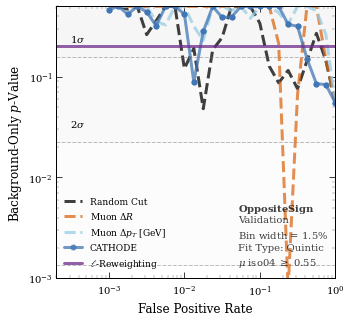

In [27]:

print(np.sqrt(full_q0_SS_alt))
fig, ax = plot_sig(feature_sigs_SS_alt, random_sigs_SS_alt, ymax = 5, ymin=1e-3, bonus =  np.sqrt(full_q0_SS_alt), line_0 = "$\\bf{OppositeSign}$", line_1 = "Validation")
plt.savefig(f"{plot_save_dir}/significance_SS_alt_{fit_type}_{num_bins_SR}_{flow_id}.pdf", bbox_inches = "tight")

In [ ]:
def plot_variations():

    fig, ax = newplot("column")


    fits = ["cubic", "quintic", "septic"]
    degrees = [3, 5, 7]
    colors = ["red", "purple", "blue"]
    linestyles = ["dashed", "solid", "dotted"]
    bins = [8, 12, 16]
    percentages = [1.1, 1.5, 2.3]

    for i, fit in enumerate(fits):
        for (j, bin) in enumerate(bins):
           with open(f"{plot_data_dir}{data_prefix}_significances_{degrees[i]}_{bin}.pickle", "rb") as file:
                sigs = pickle.load(file)

                # SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(sigs[:,1:])
                SIG_observed = sigs[:,0]
                p_values = inverse_quantile(SIG_observed)

                
                label = f"Deg. {degrees[i]}, {bin} bins"

                if i == 1 and j == 1:
                    linewidth = 3

                else:
                    linewidth = 1.5

                ax.plot(fpr_thresholds_finegrained, p_values, color = colors[i], alpha = 0.99, ls = linestyles[j], label = label, lw = linewidth)

                # 



                # # if i == 1 and j == 1, plot the lower and upper bounds
                # if i == 1 and j == 1:
                #     ax.fill_between(fpr_thresholds_finegrained, SIG_lower, SIG_upper, alpha = 0.1, color = "grey")
                #     ax.fill_between(fpr_thresholds_finegrained, SIG_2lower, SIG_2upper, alpha = 0.1, color = "grey")

                #     # plot the boundaries with a thin line
                #     ax.plot(fpr_thresholds_finegrained, SIG_lower, color = "grey", linestyle = linestyles[j], alpha = 0.5, lw = 0.5)
                #     ax.plot(fpr_thresholds_finegrained, SIG_upper, color = "grey", linestyle = linestyles[j], alpha = 0.5, lw = 0.5)

                #     ax.plot(fpr_thresholds_finegrained, SIG_2lower, color = "grey", linestyle = linestyles[j], alpha = 0.5, lw = 0.5)
                #     ax.plot(fpr_thresholds_finegrained, SIG_2upper, color = "grey", linestyle = linestyles[j], alpha = 0.5, lw = 0.5)

    plt.xscale("log")
    plt.xlabel("False Positive Rate")
    plt.ylabel("Background-Only $p$-Value")

    ymin = 1e-20
    for i in range(7+1):

        p_value = inverse_quantile(i)
        plt.axhline(p_value, color = "grey", linestyle = "dashed", alpha = 0.5, lw = 1)

        if i > 0 and inverse_quantile(i+1) > ymin:
            plt.text(3e-4, p_value * 1.5, f"{i}$\sigma$", fontsize = 10, verticalalignment = "cente")

        # fill above
        plt.fill_between([2e-4, 1], p_value, 0.5, color = "grey", alpha = 0.025)


    plt.yscale("log")

    # Make a fake 2 column legend: Column 1 is red-purple-blue for the fits, Column 2 is dashed-dotted-solid for the bins
    legend_items = []
    for i, fit in enumerate(fits):
        legend_item = mpatches.Patch(label=fit.capitalize(), edgecolor=colors[i], facecolor=colors[i], alpha = 0.5)
        legend_items.append(legend_item)

    # # Legend item for the grey band
    # legend_item = mpatches.Patch(label="Quintic, 11 bins $\pm$ 1, 2$\sigma$", edgecolor="grey", facecolor="grey", linestyle = "--", alpha = 0.5)
    # legend_items.append(legend_item)


    # Make lines for the bins, not rectange
    for j, bin in enumerate(bins):
        legend_item = plt.Line2D([0], [0], color='black', lw=1, linestyle = linestyles[j], label=f"Binwidth: {percentages[j]}\%")
        legend_items.append(legend_item)


    plt.legend(handles=legend_items, loc = "lower cente", ncol = 2, fontsize = 9, columnspacing=2, title = "CATHODE", title_fontsize = 10)
    plt.title("$\bf{2016\,\, CMS\,\, Open\,\, Data\,\, DoubleMuon}$", loc = "right", fontsize = 10)

    plt.ylim(1e-20, 0.5)
    plt.xlim(2e-4, 1)
            
plot_variations()

plt.savefig(f"{plot_save_dir}/significance_variations.pdf")

In [ ]:
# plot all the features

In [ ]:
with open(f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/upsilon_iso_03_03/processed_data/bootstrap0_OS_test_band_data", "rb") as ifile:
    all_data_OS = pickle.load(ifile)
with open(f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/upsilon_iso_03_03/processed_data/bootstrap0_SS_test_band_data", "rb") as ifile:
    all_data_SS = pickle.load(ifile)

with open(f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/upsilon_iso_03_03/processed_data/mass_scaler_bootstrap0", "rb") as ifile:
    mass_scaler = pickle.load(ifile)
with open(f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/upsilon_iso_03_03/processed_data/preprocessing_info_bootstrap0", "rb") as ifile:
    feature_scaler = pickle.load(ifile)



with open(f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/upsilon_iso_03_03/processed_data/no_iso_cut_band_OS", "rb") as ifile:
    all_data_OS_noiso = pickle.load(ifile)
with open(f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/upsilon_iso_03_03/processed_data/no_iso_cut_band_SS", "rb") as ifile:
    all_data_SS_noiso = pickle.load(ifile)




In [ ]:
all_features = list(bins.keys())
n_features = len(all_features)

fig, ax = newplot("column", width = 10, height = 8, subplot_array=(3, 4))
# fig, ax = plt.subplots(1, n_features, figsize = (9, 3))



for i_feat in range(n_features):

    
    ax.flatten()[i_feat].hist( scaled_to_physical_transform(all_data_OS["SR"][all_features[i_feat]], feature_scaler[all_features[i_feat]], 0.02), bins=bins[all_features[i_feat]], 
                              lw = 2, histtype = "step", label = "OppositeSign")
    ax.flatten()[i_feat].hist( scaled_to_physical_transform(all_data_SS["SR"][all_features[i_feat]], feature_scaler[all_features[i_feat]], 0.02), bins=bins[all_features[i_feat]], 
                              lw = 2, histtype = "step", label = "SameSign")
    ax.flatten()[i_feat].set_yscale("log")
    ax.flatten()[i_feat].set_xlabel(labels[all_features[i_feat]])


    if plot_log[all_features[i_feat]]:
        ax.flatten()[i_feat].set_xscale("log")
            

    #ax.flatten()[i_feat].tick_params()

    if i_feat in [1, 2, 3, 5, 6, 7, 9, 10, 11]:
        ax.flatten()[i_feat].set_yticklabels([])
    else:
        ax.flatten()[i_feat].set_ylabel("Counts")

starting_x = 1
starting_y = 1.75
delta_y = 0.17
text_alpha = 0.75

line0 = "$\\bf{2016 CMS Open DoubleMuon}$"
line1 = "$\\tt{HLT\_TrkMu15\_DoubleTrkMu5NoFiltersNoVtx}$"
line2 = "$\mu$ iso04 $\geq$ 0.55"
line3 = "8.7 fb$^{-1}$, $\sqrt{s} = 13$ TeV"



plt.text(starting_x, starting_y - 0 * delta_y, line0, transform=ax.flatten()[3].transAxes, fontsize=16, verticalalignment='top', horizontalalignment = "right", zorder = 10)
plt.text(starting_x, starting_y - 1 * delta_y, line1, transform=ax.flatten()[3].transAxes, fontsize=12, verticalalignment='top', horizontalalignment = "right", zorder = 10)
plt.text(starting_x, starting_y - 2 * delta_y, line2, transform=ax.flatten()[3].transAxes, fontsize=12, verticalalignment='top', horizontalalignment = "right", zorder = 10)
plt.text(starting_x, starting_y - 3 * delta_y, line3, transform=ax.flatten()[3].transAxes, fontsize=12, verticalalignment='top', horizontalalignment = "right", zorder = 10)


plt.subplots_adjust(hspace = 0.38)
legend_title = "Upsilon Resonances: Iso, Opp. Sign"
ax.flatten()[0].legend(fontsize = 12, loc = (0.1, 1.1))

#ax[0].set_ylabel("Events")
plt.subplots_adjust(wspace=0)
plt.savefig(f"plots/muon_features.pdf", bbox_inches = "tight")



In [ ]:
all_features = list(bins.keys())
n_features = len(all_features)

fig, ax = newplot("column", width = 8, height = 6, subplot_array=(1, 1))
# fig, ax = plt.subplots(1, n_features, figsize = (9, 3))

OS_masses = np.vstack([all_data_OS["SBL"]["dimu_mass"], all_data_OS["SR"]["dimu_mass"], all_data_OS["SBH"]["dimu_mass"]])
SS_masses = np.vstack([all_data_SS["SBL"]["dimu_mass"], all_data_SS["SR"]["dimu_mass"], all_data_SS["SBH"]["dimu_mass"]])

OS_masses_no_iso = np.vstack([all_data_OS_noiso["SBL"]["skimmed_data_2016H_30555_nojet"]["dimu_mass"].reshape(-1,1), all_data_OS_noiso["SR"]["skimmed_data_2016H_30555_nojet"]["dimu_mass"].reshape(-1,1), all_data_OS_noiso["SBH"]["skimmed_data_2016H_30555_nojet"]["dimu_mass"].reshape(-1,1)])
SS_masses_no_iso = np.vstack([all_data_SS_noiso["SBL"]["skimmed_data_2016H_30555_nojet"]["dimu_mass"].reshape(-1,1), all_data_SS_noiso["SR"]["skimmed_data_2016H_30555_nojet"]["dimu_mass"].reshape(-1,1), all_data_SS_noiso["SBH"]["skimmed_data_2016H_30555_nojet"]["dimu_mass"].reshape(-1,1)])

ax.hist(OS_masses_no_iso, bins=np.linspace(5, 16, 90), 
                          lw = 2, histtype = "step", label = "OppositeSign", color = "#0C5DA5", linestyle = "dashed")
ax.hist( SS_masses_no_iso, bins=np.linspace(5, 16, 90), 
                          lw = 2, histtype = "step", label = "SameSign", color = "#00B945", linestyle = "dashed")
ax.hist( mass_scaler.inverse_transform(OS_masses), bins=np.linspace(5, 16, 90), color = "#0C5DA5", 
                          lw = 3, histtype = "step", label = "OppositeSign, $\mu$ iso04 $\geq$ 0.55")
ax.hist( mass_scaler.inverse_transform(SS_masses), bins=np.linspace(5, 16, 90), color = "#00B945",
                          lw = 3, histtype = "step", label = "SameSign, $\mu$ iso04 $\geq$ 0.55")
ax.set_xlabel("Dimuon Mass $m_{\mu\mu}$ [GeV]")


ax.set_ylabel("Counts")



starting_x = 1
starting_y = 1.25
delta_y = 0.06
text_alpha = 0.75

line0 = "$\\bf{2016 CMS Open DoubleMuon}$"
line1 = "$\\tt{HLT\_TrkMu15\_DoubleTrkMu5NoFiltersNoVtx}$"
line2 = "$\mu$ iso04 $\geq$ 0.55"
line2 = "8.7 fb$^{-1}$, $\sqrt{s} = 13$ TeV"



plt.text(starting_x, starting_y - 0 * delta_y, line0, transform=ax.transAxes, fontsize=16, verticalalignment='top', horizontalalignment = "right", zorder = 10)
plt.text(starting_x, starting_y - 1 * delta_y, line1, transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment = "right", zorder = 10)
plt.text(starting_x, starting_y - 2 * delta_y, line2, transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment = "right", zorder = 10)
#plt.text(starting_x, starting_y - 3 * delta_y, line3, transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment = "right", zorder = 10)

plt.axvline(SR_left, color = "red", lw = 4, alpha = 0.6)
plt.axvline(SR_right, color = "red", lw = 4, alpha= 0.6)
#plt.text(0.2, 1.2, "SBL", transform=ax.transAxes, fontsize=16, verticalalignment='top', zorder = 10)
#plt.text(0.415, 1.2, "SR", transform=ax.transAxes, fontsize=16, verticalalignment='top', zorder = 10)
#plt.text(0.65,1.2, "SBH", transform=ax.transAxes, fontsize=16, verticalalignment='top', zorder = 10)

yy = 960
# plot the upsilon resonances
ax.axvline(9.460, color="black", linestyle="--", alpha=0.5, lw = 1.5)
ax.text(9.460 * 0.995, yy, "$\\Upsilon(1S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=12)
ax.axvline(10.023, color="black", linestyle="--", alpha=0.5, lw = 1.5)
ax.text(10.023 * 0.995, yy, "$\\Upsilon(2S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=12)
ax.axvline(10.355, color="black", linestyle="--", alpha=0.5, lw = 1.5)
ax.text(10.355 * 0.995, yy, "$\\Upsilon(3S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=12)

plt.legend(fontsize = 11)

#ax[0].set_ylabel("Events")
plt.subplots_adjust(wspace=0)
plt.savefig(f"plots/muon_masses.pdf", bbox_inches = "tight")

